In [1]:
import os
import sys
import traci
from sumolib import checkBinary 

if 'SUMO_HOME' in os.environ:
  tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
  sys.path.append(tools)
else:
  sys.exit("please declare environment variable 'SUMO_HOME'")

# variable
useGui = False
net_file = './saint_paul/junction.net.xml'
route_path = f'./saint_paul/1.0hour/trips/3000.rou.xml'

if(useGui): sumoBinary = checkBinary('sumo-gui')
else: sumoBinary = checkBinary('sumo')
sumoCmd = [sumoBinary, "-n", net_file, "-r", route_path,
           "--quit-on-end", "--waiting-time-memory", '10000',
           '--time-to-teleport', '-1', '--start']

traci.start(sumoCmd)

trafficLightId = traci.trafficlight.getIDList()[0]
allLanes = list(dict.fromkeys(traci.trafficlight.getControlledLanes(trafficLightId))) # remove duplicate
allPhases = traci.trafficlight.getAllProgramLogics(trafficLightId)[0].phases

swithTime = 10
currentPhase = 0
yellowPhase = True

def getAlllanes(edge):
  return [lane for lane in allLanes if edge in lane]

def totalVehicle(lanes: list):
  numVehicleList = [traci.lane.getLastStepVehicleNumber(lane) for lane in lanes]
  return sum(numVehicleList)

north_lane = getAlllanes('E2')
south_lane = getAlllanes('E0')
east_lane = getAlllanes('E3')
west_lane = getAlllanes('E1')

car_north = set()
car = set()
car_time = {}

while traci.simulation.getMinExpectedNumber() > 0:
  traci.simulationStep()

  """
  if vehPerHours = 3, car will come at 1s (0/3*3600 + 1), 1201s (1/3*3600 + 1) , 1801s(2/3*3600 + 1)
  if vehPerHours = 5, car will come at 1s (0/5*3600 + 1), 721s (1/5*3600 + 1) , 1441s(2/5*3600 + 1)
  """
  
  vehicles = traci.vehicle.getIDList()
  now_time = traci.simulation.getTime()
  car_time[now_time] = 0

  for vehicle in vehicles:
    if vehicle not in car:
      car.add(vehicle)
      car_time[now_time] += 1
  
traci.close()

In [2]:
total_cars = 0
for car in car_time:
  total_cars += car_time[car]
total_cars

3008

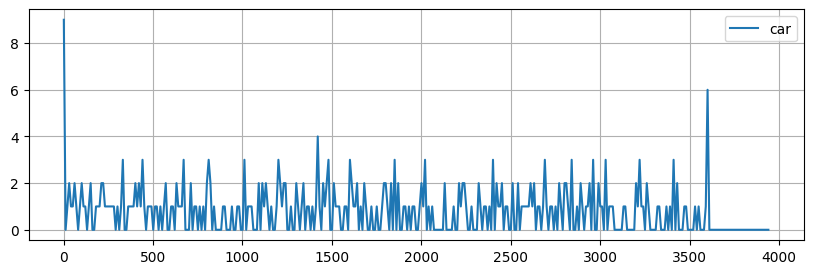

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

plt.subplots(figsize=(10, 3))
plt.plot(list(car_time.keys())[::10], list(car_time.values())[::10], label = "car")
#plt.xticks([*range(0,9000,2000)])
plt.grid()
plt.legend()
plt.show()